# **So You want a Remote job? Predicting Remote and Flexible Work Arrangements from Developer Survey Data**
**Group: Thimkers**
- Juan Miguel Miranda
- Lance Xavier Lim
---

## **Introduction**
Remote and highly flexible work arrangements have become increasingly coveted among software developers, offering benefits such as improved work-life balance, location flexibility, and expanded employment opportunities even including other countries. However, as remote roles grow more competitive, many job seekers lack clear, data-driven insights into the characteristics commonly associated with such positions.

This project applies supervised machine learning classification techniques to the Stack Overflow 2025 Developer Survey to predict whether a developer works in a remote or highly flexible work arrangement based on demographic, professional, and job-related features. By modeling patterns present in real-world survey data, the study aims to identify factors that are strongly predictive of remote or flexible work status.

---

## **Dataset Description**

**Description**

This project uses data from the Stack Overflow 2025 Developer Survey, a large-scale, annual survey conducted among software developers worldwide. The survey collects self-reported information on demographics, education, employment status, work arrangements, technologies used, and professional experience.

**survey_results_public.csv**

This file contains all of the survey responses, where each row represents a single respondent. Columns correspond to survey questions covering topics such as employment characteristics, work environment, developer role, experience level, education background, and technology usage. Responses include a mix of numerical values, categorical selections, and multi-select answers. This file serves as the main source of data.

**survey_results_schema.csv**

This file provides the metadata and schema for the multiple select questions within the survey.

**Why This Is a Real-World Dataset and Relevant to the Problem**

The Stack Overflow Developer Survey is a real-world dataset collected annually from a large and diverse population of developers. The data reflects self-reported information about respondents' actual employment conditions, work environments, and professional backgrounds, rather than synthetic or simulated data. As a result, the dataset captures real labor market conditions and work arrangements experienced by developers.

The dataset is directly relevant to the problem of predicting remote and flexible work arrangements because it explicitly includes questions about respondents' current work situations, including whether they work remotely, in person, or under flexible arrangements. Additionally, the survey contains a wide range of demographic, professional, and organizational variables. Such as role type, years of experience, education level, company characteristics, and more that can plausibly relate to work arrangement outcomes. 

Because remote work has become increasingly competitive and sought after in the software industry, understanding which characteristics are predictive of remote or highly flexible roles is a socially and professionally relevant task applicable to job seekers and recruiters.

### **Problem Definition and Machine Learning Task**

Can we build a supervised machine learning model that predicts whether a developer is employed in a remote or highly flexible work arrangement based on their professional background, using the Stack Overflow 2025 Developer Survey?

---

# **Data Preparation**

### **Scope and Inclusion**

In this project, the analysis focuses exclusively on respondents' current professional situation as captured by the Stack Overflow 2025 Developer Survey. To ensure that the predictive task reflects present-day employment conditions rather than future intentions or subjective opinions, only variables describing respondents' existing work arrangement, professional background, industry, experience, and current technology usage are considered.

Specifically, the study excludes variables that relate to future interests such as technologies respondents wish to work with in the coming year, as these do not describe their current employment situation. Preference-based and opinion-oriented responses such as personal rankings, preferences, and thoughts regarding AI will be omitted due to their subjective nature and limited relevance to predicting present work situations. Additionally, write-in "Other" custom text fields are excluded in favor of standardized response options provided by the surveyors to maintain consistency and reduce noise.

The feature set is further restricted to general industry and professional characteristics which means that questions related to Stack Overflow community engagement are excluded, as these reflect community interaction rather than employment conditions.

This scoped feature selection allows the model to focus on stable, interpretable characteristics that might plausibly relate to a developer's current work arrangement, while avoiding future-oriented thoughts, subjective preferences, and community-specific behaviors that fall outside the objective of the model.

---

### **Survey Coverage**

To efficiently explore, clean, and prepare the features for modeling, the dataset is processed section by section, following the order and structure of the Stack Overflow 2025 Developer Survey. This approach allows each group of related variables to be examined, cleaned, and transformed independently before being integrated before being used for training. For each section, missing values are identified and handled, categorical variables are standardized and encoded as needed.

The following sections of the survey are included in the analysis:

- **Education + Career**

This section contains variables describing respondents' demographic background and current professional status. Included features capture education level, years of experience, job role, and **current work arrangement**. These variables provide a foundational profile of a developer's career stage and work context.

- **Tech and Tech Culture**

This section includes respondents' current technology usage in professional settings. Variables indicate whether respondents actively worked with programming languages, database systems, web frameworks, and other tools in the past year. Only features reflecting technologies already used are included. Questions describing technologies respondents wish to use in the future or custom write-ins are excluded.

- **AI + AI Agents**

From the AI-related section, only variables describing current AI tool and AI agent usage are included. These features capture whether respondents presently use AI tools and agents as part of their work. Subjective variables such as opinions about AI, trust levels, or frustrations are excluded since they reflect subjective beliefs.

---

In [32]:
# %pip install scikit_posthocs
# %pip install scikit-learn
# %pip install plotly

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from scipy.stats import pearsonr, spearmanr, levene, f_oneway, shapiro, kruskal, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

survey_data = pd.read_csv('survey_results_public.csv')
survey_schema = pd.read_csv('survey_results_schema.csv') # I don't think this is needed

print(f"Survey data shape: {survey_data.shape}")
print(f"Schema data shape: {survey_schema.shape}")

survey_data.head()

Survey data shape: (49191, 172)
Schema data shape: (139, 6)


C:\Users\Admin\AppData\Local\Temp\ipykernel_23160\120944736.py:22: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data = pd.read_csv('survey_results_public.csv')


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code,NaN,When I don’t trust AI’s answers;When I want to...,NaN,36197.0,6.0
4,5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...",60000.0,7.0


### **Functions Import**

In [33]:
%load_ext autoreload
%autoreload 2
import importlib
import functions
importlib.reload(functions)

funcs = functions.Functions()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Checking Duplicates**

None were found

In [34]:
results = funcs.view_duplicates(survey_data)

Duplicate Row Check:
Total rows: 49191
Duplicate rows: 0


### **Creating Target Variable**

The target variable can be found in the RemoteWork column. To define successes and failures, full Remote and Your Choice as both successes. Marking them both as 1 and all else as 0. In future analysis, NA or nan will be considered as not currently employed.

In [35]:
remote_flexible_conditions = [
    'Remote',
    'Your choice (very flexible, you can come in when you want or just as needed)'
]

target = survey_data['RemoteWork'].apply(
    lambda x: 1 if x in remote_flexible_conditions else 0
)

print("Target Variables:")
target_counts = target.value_counts()
total_rows = len(target)

for value, count in target_counts.items():
    percentage = (count / total_rows) * 100
    print(f"{value}: {count} ({percentage:.2f}%)")

Target Variables:
0: 34016 (69.15%)
1: 15175 (30.85%)


### **Education + Career**

**Current Profession**

The original current profession variable (main branch) contains six nominal categories:

- I am a developer by profession
- I am not primarily a developer, but I write code sometimes as part of my work/studies
- I am learning to code
- I code primarily as a hobby
- I used to be a developer by profession, but no longer am
- I work with developers or my work supports developers but am not a developer by profession

To reduce noise and over-fragmentation, these responses were compressed into four groupings that better reflect respondents’ current level of professional involvement. To make it digestible to ML models, the categories were one-hot encoded.

| Compressed Category     | Original Responses                                                                                                                          |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| Professional dev    | I am a developer by profession                                                                                                              |
| Non-primary dev     | I am not primarily a developer, but I write code sometimes as part of my work/studies                                                       |
| Learner or hobbyist | I am learning to code; I code primarily as a hobby                                                                                          |
| Retired or non-dev  | I used to be a developer by profession, but no longer am; I work with developers or support developers but am not a developer by profession |



In [36]:
current_profession = survey_data['MainBranch'].apply(funcs.compress_mainbranch)
# Put a prefix on all one-hot encoded columns to make sure none ever get mixed up
current_profession_encoded = pd.get_dummies(current_profession, prefix='profession')

print(f"\nOne-hot encoded features created:")
print(f"Shape: {current_profession_encoded.shape}")
print(f"Columns: {list(current_profession_encoded.columns)}")

current_profession_encoded


One-hot encoded features created:
Shape: (49191, 4)
Columns: ['profession_learner or hobbyist', 'profession_non-primary dev', 'profession_professional dev', 'profession_retired or non-dev']


,profession_learner or hobbyist,profession_non-primary dev,profession_professional dev,profession_retired or non-dev
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
49186,True,False,False,False
49187,False,False,True,False
49188,False,False,True,False
49189,False,False,True,False


### **Age Group, Highest Education Level, and Employment**

To prepare the categorical variables for machine learning modeling, compression and one-hot encoding was applied to reduce noise and make columns more concise.

**Compression Strategy Overview:**

1. **Current Profession (MainBranch)**: Compressed from 6 original categories to 4 groupings:
- Professional developer
- Non-primary developer (code sometimes)
- Learner or hobbyist
- Retired or non-developer

2. **Education Level**: Compressed from 9 original categories to 8 standardized levels, with NaN values put into to "other":
- bachelor, master, professional, associate
- went to college without degree, secondary school, primary school
- other

3. **Employment Status**: Compressed from 7 original categories to 6 employment status:
- employed, independent, unemployed,  students
- retired, others (includes NaN and "prefer not to say")

In [37]:
# One-hot encode Age groups
age_group = pd.get_dummies(survey_data['Age'], prefix='age_group')

print(f"\nOne-hot encoded age groups:")
print(f"Shape: {age_group.shape}")
print(f"Columns: {list(age_group.columns)}")

# One-hot encode education levels
compressed_education = survey_data['EdLevel'].apply(funcs.compress_education)
education_level = pd.get_dummies(compressed_education, prefix='ed_level')

print(f"\nOne-hot encoded education levels:")
print(f"Shape: {education_level.shape}")
print(f"Columns: {list(education_level.columns)}")

# One-hot encode Employment status
compressed_employment = survey_data['Employment'].apply(funcs.compress_employment)
employment_status = pd.get_dummies(compressed_employment, prefix='employment')

print(f"\nOne-hot encoded employment status:")
print(f"Shape: {employment_status.shape}")
print(f"Columns: {list(employment_status.columns)}")

employment_status


One-hot encoded age groups:
Shape: (49191, 7)
Columns: ['age_group_18-24 years old', 'age_group_25-34 years old', 'age_group_35-44 years old', 'age_group_45-54 years old', 'age_group_55-64 years old', 'age_group_65 years or older', 'age_group_Prefer not to say']

One-hot encoded education levels:
Shape: (49191, 8)
Columns: ['ed_level_associate', 'ed_level_bachelor', 'ed_level_master', 'ed_level_other', 'ed_level_primary school', 'ed_level_professional', 'ed_level_secondary school', 'ed_level_went to college without degree']

One-hot encoded employment status:
Shape: (49191, 6)
Columns: ['employment_employed', 'employment_independent', 'employment_others', 'employment_retired', 'employment_student', 'employment_unemployed']


,employment_employed,employment_independent,employment_others,employment_retired,employment_student,employment_unemployed
0,True,False,False,False,False,False
1,True,False,False,False,False,False
2,False,True,False,False,False,False
3,True,False,False,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
49186,True,False,False,False,False,False
49187,True,False,False,False,False,False
49188,True,False,False,False,False,False
49189,False,True,False,False,False,False


### **Developer Type**

The DevType variable originally contained 33 distinct developer roles and specializations. To create more meaningful feature groups, these were compressed into 22 categories to combine smaller groups and create wider yet accurate generalizations.

**Developer Categories:**
- Full-stack, Backend, Frontend, Mobile, Desktop, Embedded, Game, AI/ML developers

**Specialized Roles:**
- Software architects, Data specialists, DevOps/Infrastructure, Database specialists, Security specialists, UX/UI designers

**Other Professional Roles:**
- QA, Managers, Executives/Founders, Researchers/Scientists, Support/Analysts

**Non-Professional:**
- Students, Retired, Others (including NaN and unspecified)

In [38]:
# One-hot encode Developer Type
compressed_devtype = survey_data['DevType'].apply(funcs.compress_devtype)
dev_type_encoded = pd.get_dummies(compressed_devtype, prefix='devtype')

print(f"\nOne-hot encoded developer types:")
print(f"Shape: {dev_type_encoded.shape}")
print(f"Columns: {list(dev_type_encoded.columns)}")

# Show the compression results
print(f"\nCompressed developer type distribution:")
devtype_counts = compressed_devtype.value_counts()
total_rows = len(compressed_devtype)

dev_type_encoded


One-hot encoded developer types:
Shape: (49191, 22)
Columns: ['devtype_ai/ml developer', 'devtype_backend developer', 'devtype_data specialist', 'devtype_database specialist', 'devtype_desktop developer', 'devtype_devops/infrastructure', 'devtype_embedded developer', 'devtype_executive/leader', 'devtype_frontend developer', 'devtype_full-stack developer', 'devtype_game developer', 'devtype_manager', 'devtype_mobile developer', 'devtype_others', 'devtype_qa tester', 'devtype_researcher/scientist', 'devtype_retired', 'devtype_security specialist', 'devtype_software architect', 'devtype_student', 'devtype_support/analyst', 'devtype_ux/ui designer']

Compressed developer type distribution:


,devtype_ai/ml developer,devtype_backend developer,devtype_data specialist,devtype_database specialist,devtype_desktop developer,devtype_devops/infrastructure,devtype_embedded developer,devtype_executive/leader,devtype_frontend developer,devtype_full-stack developer,...,devtype_mobile developer,devtype_others,devtype_qa tester,devtype_researcher/scientist,devtype_retired,devtype_security specialist,devtype_software architect,devtype_student,devtype_support/analyst,devtype_ux/ui designer
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49186,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
49187,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
49188,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
49189,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


### **Years and Experience**

Just a general overview of numerical data. For now its here, maybe move to EDA. 

DONT SCALE YET. DO IT AFTER TEST TRAIN SPLIT

count    42893.000000
mean        13.367403
std         10.800117
min          1.000000
25%          5.000000
50%         10.000000
75%         20.000000
max        100.000000
Name: WorkExp, dtype: float64

count    43042.000000
mean        16.570861
std         11.787610
min          1.000000
25%          8.000000
50%         14.000000
75%         24.000000
max        100.000000
Name: YearsCode, dtype: float64


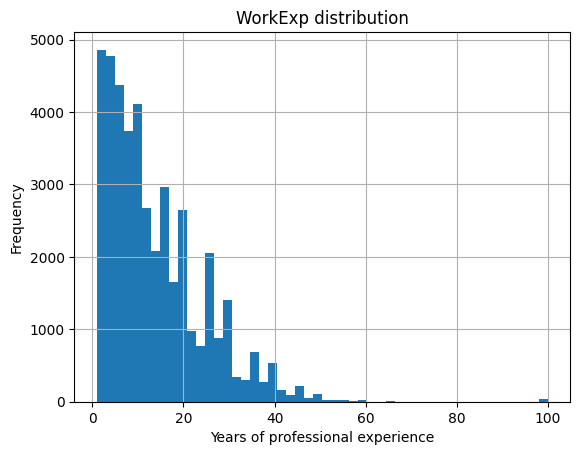

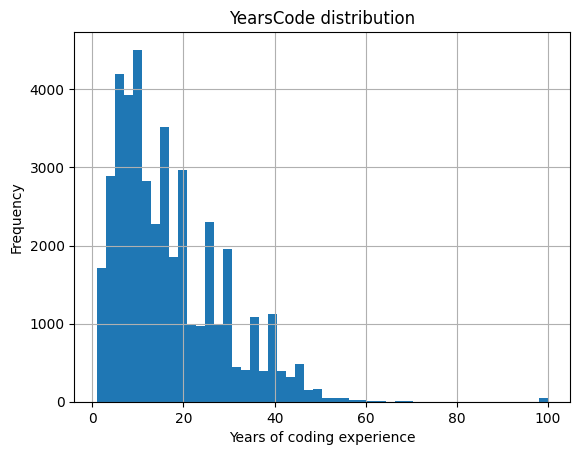

In [39]:
work_years = survey_data["WorkExp"]
learn_years = survey_data["YearsCode"]

work_summary = work_years.describe()
print(work_summary)

print("")

learn_summary = learn_years.describe()
print(learn_summary)

work_years.hist(bins=50)
plt.title("WorkExp distribution")
plt.xlabel("Years of professional experience")
plt.ylabel("Frequency")
plt.show()

learn_years.hist(bins=50)
plt.title("YearsCode distribution")
plt.xlabel("Years of coding experience")
plt.ylabel("Frequency")
plt.show()


### **Organization Size**

The organization size variable contains categories that represent a natural ordering from smallest to largest companies. Unlike the previous categorical variables that are purely nominal.

Because of this, it was assigned and ordered from 0 to 8 to preserve the natural ordering.

In [40]:
org_size_ordinal = survey_data['OrgSize'].apply(funcs.orgsize_ordinal)

print(f"\nOrdinal value distribution:")
ordinal_counts = org_size_ordinal.value_counts().sort_index()
total_rows = len(org_size_ordinal)

for value, count in ordinal_counts.items():
    percentage = (count / total_rows) * 100
    print(f"Value {value}: {count} ({percentage:.2f}%)")



Ordinal value distribution:
Value 0: 15945 (32.41%)
Value 1: 1763 (3.58%)
Value 2: 12288 (24.98%)
Value 3: 6109 (12.42%)
Value 4: 2361 (4.80%)
Value 5: 4156 (8.45%)
Value 6: 1604 (3.26%)
Value 7: 4965 (10.09%)


### **How Many Distinct Software Do You Use**

The survey includes questions about the number of distinct software tools developers use both for work and personal projects. These variables capture the range in their toolkits..

The original responses contained a very wide range of values, from 0 to extremely high numbers like 999. Many of these extreme values appear to be unserious responses so tool counts were put into 6 groups:
   - 0 tools
   - 1 to 5 tools
   - 6 to 10 tools  
   - 11 to 15 tools
   - 16 to 20 tools
   - More than 20 tools

In [41]:
work_tool_count = survey_data['ToolCountWork'].apply(funcs.process_tool_count)
work_tool_groups = work_tool_count.apply(funcs.group_tool_count)

print("Tool Counts (Work):")
tool_counts = work_tool_count.value_counts().sort_index()
total_rows = len(work_tool_count)

# print(f"\Counts Distribution:")
# for value, count in tool_counts.items():
#     percentage = (count / total_rows) * 100
#     print(f"{value} tools: {count} ({percentage:.2f}%)")

print(f"\nSummary statistics:")
print(f"Mean: {work_tool_count.mean():.2f}")
print(f"Median: {work_tool_count.median():.0f}")
print(f"Standard deviation: {work_tool_count.std():.2f}")

work_tool_groups_counts = work_tool_groups.value_counts()
total_rows = len(work_tool_groups)

print(f"\nTool Count Groups Distribution:")
for group in ['0', '1 to 5', '6 to 10', '11 to 15', '16 to 20', 'More than 20']:
    count = work_tool_groups_counts.get(group, 0)
    percentage = (count / total_rows) * 100
    print(f"{group} tools: {count} ({percentage:.2f}%)")


Tool Counts (Work):

Summary statistics:
Mean: 9.95
Median: 3
Standard deviation: 202.33

Tool Count Groups Distribution:
0 tools: 21744 (44.20%)
1 to 5 tools: 12486 (25.38%)
6 to 10 tools: 9716 (19.75%)
11 to 15 tools: 2612 (5.31%)
16 to 20 tools: 1407 (2.86%)
More than 20 tools: 1226 (2.49%)


In [42]:
personal_tool_count = survey_data['ToolCountPersonal'].apply(funcs.process_tool_count)
personal_tool_groups = personal_tool_count.apply(funcs.group_tool_count)

print("Tool Counts (Work):")
tool_counts = personal_tool_count.value_counts().sort_index()
total_rows = len(personal_tool_count)

# print(f"\Counts Distribution:")
# for value, count in tool_counts.items():
#     percentage = (count / total_rows) * 100
#     print(f"{value} tools: {count} ({percentage:.2f}%)")

print(f"\nSummary statistics:")
print(f"Mean: {personal_tool_count.mean():.2f}")
print(f"Median: {personal_tool_count.median():.0f}")
print(f"Standard deviation: {personal_tool_count.std():.2f}")

personal_tool_groups_counts = personal_tool_groups.value_counts()
total_rows = len(personal_tool_groups)

print(f"\nTool Count Groups Distribution:")
for group in ['0', '1 to 5', '6 to 10', '11 to 15', '16 to 20', 'More than 20']:
    count = personal_tool_groups_counts.get(group, 0)
    percentage = (count / total_rows) * 100
    print(f"{group} tools: {count} ({percentage:.2f}%)")


Tool Counts (Work):

Summary statistics:
Mean: 4.44
Median: 1
Standard deviation: 32.49

Tool Count Groups Distribution:
0 tools: 24299 (49.40%)
1 to 5 tools: 16476 (33.49%)
6 to 10 tools: 5693 (11.57%)
11 to 15 tools: 1165 (2.37%)
16 to 20 tools: 752 (1.53%)
More than 20 tools: 806 (1.64%)


### **Country**

The Country variable originally contains over 170+ different countries. To make this more manageable for machine learning and to capture meaningful geographic patterns that might relate to remote work culture, countries were grouped using the UN Geoscheme as the standard.

- **Northern America**: USA, Canada
- **Western Europe**: Germany, UK, France, Netherlands, Switzerland, etc.
- **Northern Europe**: Sweden, Norway, Denmark, Finland, Iceland, Baltic states
- **Southern Europe**: Spain, Italy, Portugal, Greece, Malta, Cyprus, Croatia, Slovenia
- **Eastern Europe**: Poland, Czech Republic, Ukraine, Hungary, Romania, Russia, etc.
- **Eastern Asia**: China, Japan, South Korea, North Korea, Mongolia, Taiwan, Hong Kong
- **South-Eastern Asia**: Philippines, Indonesia, Thailand, Malaysia, Vietnam, Singapore, etc.
- **Southern Asia**: India, Pakistan, Bangladesh, Sri Lanka, Nepal, Afghanistan, etc.
- **Western Asia**: Turkey, Israel, Jordan, Lebanon, Saudi Arabia, UAE, Iran, etc.
- **Central Asia**: Kazakhstan, Uzbekistan, Turkmenistan, Kyrgyzstan, Tajikistan
- **Northern Africa**: Egypt, Libya, Tunisia, Algeria, Morocco, Sudan
- **Western Africa**: Nigeria, Ghana, Senegal, Mali, etc.
- **Eastern Africa**: Kenya, Uganda, Tanzania, Ethiopia, Rwanda, Madagascar, etc.
- **Middle Africa**: Cameroon, Chad, Democratic Republic of Congo, Angola, etc.
- **Southern Africa**: South Africa, Botswana, Namibia, Zimbabwe, Zambia, etc.
- **Central America**: Mexico, Guatemala, Honduras, El Salvador, Nicaragua, Costa Rica, Panama, Belize
- **Caribbean**: Cuba, Dominican Republic, Jamaica, Trinidad and Tobago, Haiti, etc.
- **South America**: Brazil, Argentina, Chile, Colombia, Peru, Venezuela, Ecuador, etc.
- **Australia and New Zealand**: Australia, New Zealand, Fiji
- **Other**: Microstates, dependencies, and unspecified countries

In [43]:
# Apply geographic grouping to countries
geographic_regions = survey_data['Country'].apply(funcs.group_countries)
geographic_regions_encoded = pd.get_dummies(geographic_regions, prefix='region')

print("Geographic Regions Distribution:")
region_counts = geographic_regions.value_counts()
total_rows = len(geographic_regions)

for region, count in region_counts.items():
    percentage = (count / total_rows) * 100
    print(f"{region}: {count} ({percentage:.2f}%)")

geographic_regions_encoded

Geographic Regions Distribution:
other: 13806 (28.07%)
western_europe: 8852 (18.00%)
northern_america: 8538 (17.36%)
eastern_europe: 3816 (7.76%)
southern_asia: 3209 (6.52%)
southern_europe: 2333 (4.74%)
northern_europe: 1669 (3.39%)
south_america: 1610 (3.27%)
western_asia: 1084 (2.20%)
australia_new_zealand: 1064 (2.16%)
south_eastern_asia: 792 (1.61%)
eastern_asia: 732 (1.49%)
central_america: 388 (0.79%)
southern_africa: 303 (0.62%)
northern_africa: 295 (0.60%)
western_africa: 282 (0.57%)
eastern_africa: 265 (0.54%)
caribbean: 61 (0.12%)
central_asia: 59 (0.12%)
middle_africa: 33 (0.07%)


,region_australia_new_zealand,region_caribbean,region_central_america,region_central_asia,region_eastern_africa,region_eastern_asia,region_eastern_europe,region_middle_africa,region_northern_africa,region_northern_america,region_northern_europe,region_other,region_south_america,region_south_eastern_asia,region_southern_africa,region_southern_asia,region_southern_europe,region_western_africa,region_western_asia,region_western_europe
0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49186,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
49187,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
49188,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
49189,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [44]:
# Check which countries are being classified as "other"
other_countries = funcs.print_other_countries(survey_data)

Nomadic: 29 (0.06%)
Isle of Man: 10 (0.02%)
Andorra: 6 (0.01%)
Papua New Guinea: 3 (0.01%)
Micronesia, Federated States of...: 2 (0.00%)
San Marino: 1 (0.00%)
Palau: 1 (0.00%)
Total 'other': 52 (0.11%)


### **Yearly Compensation**

The yearly compensation variable represents total compensation. While this would be a valuable predictor for remote work arrangements, several significant data quality issues make it unsuitable.

1. **High Missing Data Rate**: Nearly 50% of responses have missing compensation data since disclosure is optional and sensitive.
2. **Extreme Outliers**: The dataset contains questionable entries exceeding realistic compensation ranges, which severely skew the mean and standard deviation.
3. **Optional Data**: Since compensation disclosure is voluntary, the available data may not be representative of real-world conditions as well as have bias in sampling.

Given these substantial data quality issues, yearly compensation is excluded from the feature set. Additionally, since geographic regions are already captured, currency information would be unnecessary as well.

In [45]:
yearly_compensation = survey_data["CompTotal"]

yearly_compensation_summary = yearly_compensation.describe()
print(yearly_compensation_summary)

zero_count = (yearly_compensation == 0).sum()
nan_count = yearly_compensation.isna().sum()
total_count = len(yearly_compensation)

print(f"Zero values: {zero_count:,} ({zero_count/total_count*100:.2f}%)")
print(f"NaN values: {nan_count:,} ({nan_count/total_count*100:.2f}%)")

count    2.486600e+04
mean     2.234198e+70
std      3.523096e+72
min      0.000000e+00
25%      5.500000e+04
50%      1.050000e+05
75%      2.400000e+05
max      5.555556e+74
Name: CompTotal, dtype: float64
Zero values: 751 (1.53%)
NaN values: 24,325 (49.45%)


## **Technology Skills and Tools**

The Stack Overflow 2025 Developer Survey captures extensive information about the technologies, tools, and platforms that developers actively used in the past year. These multi-select questions provide valuable insights into skill sets that may correlate with remote work opportunities.

**Feature Engineering System:**
The multi-select approach results in multiple items separated by a semicolon such as:
Dart;HTML/CSS;JavaScript;TypeScript. Sometimes with more than 40 different tools to select. Where respondents pick those that they extensively used in the past year.

**Top 25% Selection Strategy:**

Based on the Pareto Principle (80/20 rule) with additional allowance, we select the top 25% of skills from each category. This approach is justified by:

1. **Pareto Principle Foundation**: The 80/20 rule suggests that 80% of usage typically comes from 20% of technologies
2. **Market Demand Focus**: The top 25% represents the most in-demand, widely-adopted skills in the industry
3. **Remote Work Relevance**: Popular technologies are more likely to correlate with remote opportunities due to higher demand, a thriving ecosystem, and being more well-supported.
4. **Noise Reduction**: Excludes rarely-used or niche technologies that may introduce noise without meaningful predictive power

**Technology Categories:**

1. **Programming Languages**: Programming, scripting, and markup languages

2. **Database Systems**: Database environments

3. **Cloud Platforms and Infrastructure**: Cloud platforms, containerization/orchestration tools, package managers, build tools, and infrastructure solutions

4. **Web Frameworks**: Web frameworks and web technologies

5. **Development Environments**: Development environments and AI-enabled code editing tools

6. **Collaboration Tools**: Collaborative work management and code documentation tools

7. **AI Models**: LLM models for AI tools used for development work

**Data Processing:**

Each skill name undergoes standardized cleaning to create valid column names:
- All text converted to lowercase
- Spaces converted to underscores
- Special characters like #, +, / replaced with readable alternatives (sharp, plus, _)
- Parentheses and hyphens removed or converted

The survey also included binary questions asking whether respondents extensively used each technology category (yes/no/don't know). However, to obtain more relevant data, we focused on the specific technologies used rather than general category participation. As such, these questions were omitted.

In [46]:
# Programming Languages
language_features = funcs.encode_skills(survey_data, 'LanguageHaveWorkedWith', 'lang', top_perc=25)

Skill Analysis for 'LanguageHaveWorkedWith':
Unique skills: 42
Average skills count: 6.14
Using top 25% = 10 skills out of 42 total
Skills: ['JavaScript', 'HTML/CSS', 'SQL', 'Python', 'Bash/Shell (all shells)', 'TypeScript', 'Java', 'C#', 'C++', 'PowerShell']

Skill features created:
Shape: (49191, 10)
Columns: ['lang_javascript', 'lang_html_css', 'lang_sql', 'lang_python', 'lang_bash_shell_all_shells', 'lang_typescript', 'lang_java', 'lang_csharp', 'lang_cplusplus', 'lang_powershell']

Top 10 skill usage rates:
javascript: 42.7%
html css: 40.0%
sql: 37.9%
python: 37.4%
bash shell all shells: 31.5%
typescript: 28.2%
java: 19.0%
csharp: 18.0%
cplusplus: 15.2%
powershell: 15.0%


In [47]:
# Database Systems  
database_features = funcs.encode_skills(survey_data, 'DatabaseHaveWorkedWith', 'db', top_perc=25)

Skill Analysis for 'DatabaseHaveWorkedWith':
Unique skills: 30
Average skills count: 3.53
Using top 25% = 8 skills out of 30 total
Skills: ['PostgreSQL', 'MySQL', 'SQLite', 'Microsoft SQL Server', 'Redis', 'MongoDB', 'MariaDB', 'Elasticsearch']

Skill features created:
Shape: (49191, 8)
Columns: ['db_postgresql', 'db_mysql', 'db_sqlite', 'db_microsoft_sql_server', 'db_redis', 'db_mongodb', 'db_mariadb', 'db_elasticsearch']

Top 8 skill usage rates:
postgresql: 29.5%
mysql: 21.5%
sqlite: 19.9%
microsoft sql server: 16.0%
redis: 14.9%
mongodb: 12.7%
mariadb: 11.9%
elasticsearch: 8.8%


In [48]:
# Cloud Platforms and Infrastructure
platform_features = funcs.encode_skills(survey_data, 'PlatformHaveWorkedWith', 'platform', top_perc=25)

Skill Analysis for 'PlatformHaveWorkedWith':
Unique skills: 42
Average skills count: 7.14
Using top 25% = 10 skills out of 42 total
Skills: ['Docker', 'npm', 'Amazon Web Services (AWS)', 'Pip', 'Kubernetes', 'Microsoft Azure', 'Homebrew', 'Vite', 'Google Cloud', 'Make']

Skill features created:
Shape: (49191, 10)
Columns: ['platform_docker', 'platform_npm', 'platform_amazon_web_services_aws', 'platform_pip', 'platform_kubernetes', 'platform_microsoft_azure', 'platform_homebrew', 'platform_vite', 'platform_google_cloud', 'platform_make']

Top 10 skill usage rates:
docker: 35.4%
npm: 28.3%
amazon web services aws: 21.6%
pip: 20.4%
kubernetes: 14.2%
microsoft azure: 13.1%
homebrew: 12.8%
vite: 12.6%
google cloud: 12.2%
make: 11.6%


In [49]:
# Web Frameworks
webframe_features = funcs.encode_skills(survey_data, 'WebframeHaveWorkedWith', 'webframe', top_perc=25)

Skill Analysis for 'WebframeHaveWorkedWith':
Unique skills: 28
Average skills count: 3.78
Using top 25% = 7 skills out of 28 total
Skills: ['Node.js', 'React', 'jQuery', 'Next.js', 'Express', 'ASP.NET Core', 'Angular']

Skill features created:
Shape: (49191, 7)
Columns: ['webframe_node_js', 'webframe_react', 'webframe_jquery', 'webframe_next_js', 'webframe_express', 'webframe_asp_net_core', 'webframe_angular']

Top 7 skill usage rates:
node js: 23.5%
react: 21.5%
jquery: 11.3%
next js: 10.0%
express: 9.6%
asp net core: 9.5%
angular: 8.8%


In [50]:
# Development Environments
devenv_features = funcs.encode_skills(survey_data, 'DevEnvsHaveWorkedWith', 'devenv', top_perc=25)

Skill Analysis for 'DevEnvsHaveWorkedWith':
Unique skills: 27
Average skills count: 3.63
Using top 25% = 7 skills out of 27 total
Skills: ['Visual Studio Code', 'Visual Studio', 'Notepad++', 'IntelliJ IDEA', 'Vim', 'Cursor', 'PyCharm']

Skill features created:
Shape: (49191, 7)
Columns: ['devenv_visual_studio_code', 'devenv_visual_studio', 'devenv_notepadplusplus', 'devenv_intellij_idea', 'devenv_vim', 'devenv_cursor', 'devenv_pycharm']

Top 7 skill usage rates:
visual studio code: 40.4%
visual studio: 15.4%
notepadplusplus: 14.6%
intellij idea: 14.4%
vim: 12.9%
cursor: 9.5%
pycharm: 8.0%


In [51]:
# Collaboration Tools
collab_features = funcs.encode_skills(survey_data, 'OfficeStackAsyncHaveWorkedWith', 'collab', top_perc=25)

Skill Analysis for 'OfficeStackAsyncHaveWorkedWith':
Unique skills: 25
Average skills count: 3.81
Using top 25% = 6 skills out of 25 total
Skills: ['GitHub', 'Jira', 'GitLab', 'Markdown File', 'Confluence', 'Azure Devops']

Skill features created:
Shape: (49191, 6)
Columns: ['collab_github', 'collab_jira', 'collab_gitlab', 'collab_markdown_file', 'collab_confluence', 'collab_azure_devops']

Top 6 skill usage rates:
github: 49.6%
jira: 28.4%
gitlab: 21.8%
markdown file: 21.3%
confluence: 20.1%
azure devops: 10.2%


In [52]:
# AI Models
aimodel_features = funcs.encode_skills(survey_data, 'AIModelsHaveWorkedWith', 'aimodel', top_perc=25)

Skill Analysis for 'AIModelsHaveWorkedWith':
Unique skills: 17
Average skills count: 3.49
Using top 25% = 4 skills out of 17 total
Skills: ['openAI GPT (chatbot models)', 'Anthropic: Claude Sonnet', 'Gemini (Flash general purpose models)', 'openAI Reasoning models']

Skill features created:
Shape: (49191, 4)
Columns: ['aimodel_openai_gpt_chatbot_models', 'aimodel_anthropic:_claude_sonnet', 'aimodel_gemini_flash_general_purpose_models', 'aimodel_openai_reasoning_models']

Top 4 skill usage rates:
openai gpt chatbot models: 27.3%
anthropic: claude sonnet: 14.4%
gemini flash general purpose models: 11.8%
openai reasoning models: 11.6%


In [53]:
# Technology Skills Summary
print(f"\n{'='*50}")
print("TECHNOLOGY SKILLS SUMMARY")
print(f"{'='*50}")
print(f"Programming Languages: {language_features.shape[1]} features")
print(f"Database Systems: {database_features.shape[1]} features") 
print(f"Cloud/Infrastructure: {platform_features.shape[1]} features")
print(f"Web Frameworks: {webframe_features.shape[1]} features")
print(f"Development Environments: {devenv_features.shape[1]} features")
print(f"Collaboration Tools: {collab_features.shape[1]} features")
print(f"AI Models: {aimodel_features.shape[1]} features")

total_tech_features = (language_features.shape[1] + database_features.shape[1] + 
                      platform_features.shape[1] + webframe_features.shape[1] +
                      devenv_features.shape[1] + collab_features.shape[1] + aimodel_features.shape[1])
print(f"\nTotal Technology Features: {total_tech_features}")
print(f"{'='*50}")


TECHNOLOGY SKILLS SUMMARY
Programming Languages: 10 features
Database Systems: 8 features
Cloud/Infrastructure: 10 features
Web Frameworks: 7 features
Development Environments: 7 features
Collaboration Tools: 6 features
AI Models: 4 features

Total Technology Features: 52


## **AI Usage**

In [54]:
ai_industry_use = funcs.encode_skills(survey_data, 'AIAgent_Uses', 'ai_uses', top_perc=100)

Skill Analysis for 'AIAgent_Uses':
Unique skills: 10
Average skills count: 1.89
Using top 100% = 10 skills out of 10 total
Skills: ['Software engineering', 'Data and analytics', 'IT operations', 'Business process automation', 'Decision intelligence', 'Customer service support', 'Marketing', 'Cybersecurity', 'Robotics', 'Other Industry purpose (write in):']

Skill features created:
Shape: (49191, 10)
Columns: ['ai_uses_software_engineering', 'ai_uses_data_and_analytics', 'ai_uses_it_operations', 'ai_uses_business_process_automation', 'ai_uses_decision_intelligence', 'ai_uses_customer_service_support', 'ai_uses_marketing', 'ai_uses_cybersecurity', 'ai_uses_robotics', 'ai_uses_other_industry_purpose_write_in:']

Top 10 skill usage rates:
software engineering: 20.9%
data and analytics: 6.2%
it operations: 4.5%
business process automation: 4.4%
decision intelligence: 2.8%
customer service support: 2.8%
marketing: 2.2%
cybersecurity: 1.8%
robotics: 1.0%
other industry purpose write in:: 0.5%

In [55]:
# One-hot encode LearnCodeAI answers
compressed_learncodeai = survey_data['LearnCodeAI'].apply(funcs.compress_learncodeai)
learncodeai_encoded = pd.get_dummies(compressed_learncodeai, prefix='learncodeai')

print(f"\nOne-hot encoded yes/no answers to did you learn AI tools in the past year?:")
print(f"Shape: {learncodeai_encoded.shape}")
print(f"Columns: {list(learncodeai_encoded.columns)}")

# Show the compression results
print(f"\nCompressed answer distribution:")
learncodeai_counts = compressed_learncodeai.value_counts()
total_rows = len(compressed_learncodeai)

print(learncodeai_counts)
print(f"Total rows: {total_rows}")
learncodeai_encoded


One-hot encoded yes/no answers to did you learn AI tools in the past year?:
Shape: (49191, 3)
Columns: ['learncodeai_no', 'learncodeai_others', 'learncodeai_yes']

Compressed answer distribution:
LearnCodeAI
yes       30430
no        14771
others     3990
Name: count, dtype: int64
Total rows: 49191


,learncodeai_no,learncodeai_others,learncodeai_yes
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
49186,False,True,False
49187,False,False,True
49188,False,False,True
49189,False,False,True


In [56]:
ai_learn_how = funcs.encode_skills(survey_data, 'AILearnHow', 'ai_learn_how', top_perc=100)

Skill Analysis for 'AILearnHow':
Unique skills: 13
Average skills count: 2.87
Using top 100% = 13 skills out of 13 total
Skills: ['AI CodeGen tools or AI-enabled apps', 'Other online resources (e.g. standard search, forum, online community)', 'Technical documentation (is generated for/by the tool or system)', 'Videos (not associated with specific online course or certification)', 'Blogs or podcasts', 'Colleague or on-the-job training', 'Stack Overflow or Stack Exchange', 'Online Courses or Certification (includes all media types)', 'Books / Physical media', 'School (i.e., University, College, etc)', 'Other (please specify):', 'Games or coding challenges', 'Coding Bootcamp']

Skill features created:
Shape: (49191, 13)
Columns: ['ai_learn_how_ai_codegen_tools_or_ai_enabled_apps', 'ai_learn_how_other_online_resources_e_g__standard_search,_forum,_online_community', 'ai_learn_how_technical_documentation_is_generated_for_by_the_tool_or_system', 'ai_learn_how_videos_not_associated_with_specif

In [57]:
# One-hot encode AISelect answers
compressed_aiselect = survey_data['AISelect'].apply(funcs.compress_aiselect)
aiselect_encoded = pd.get_dummies(compressed_aiselect, prefix='aiselect')

print(f"\nOne-hot encoded AI use frequency:")
print(f"Shape: {aiselect_encoded.shape}")
print(f"Columns: {list(aiselect_encoded.columns)}")

# Show the compression results
print(f"\nCompressed answer distribution:")
aiselect_counts = compressed_aiselect.value_counts()
total_rows = len(compressed_aiselect)

print(aiselect_counts)
print(f"Total rows: {total_rows}")
aiselect_encoded


One-hot encoded AI use frequency:
Shape: (49191, 5)
Columns: ['aiselect_daily', 'aiselect_infrequently', 'aiselect_no', 'aiselect_others', 'aiselect_weekly']

Compressed answer distribution:
AISelect
daily           15883
others          15471
no               7251
weekly           5958
infrequently     4628
Name: count, dtype: int64
Total rows: 49191


,aiselect_daily,aiselect_infrequently,aiselect_no,aiselect_others,aiselect_weekly
0,False,True,False,False,False
1,False,False,False,False,True
2,True,False,False,False,False
3,False,False,False,False,True
4,False,False,False,False,True
...,...,...,...,...,...
49186,False,False,False,True,False
49187,False,False,False,True,False
49188,False,True,False,False,False
49189,False,False,False,True,False


In [63]:
# One-hot encode AIAgents answers
compressed_aiagents = survey_data['AIAgents'].apply(funcs.compress_aiagents)
aiagents_encoded = pd.get_dummies(compressed_aiagents, prefix='aiagents')

print(f"\nOne-hot encoded AI agents:")
print(f"Shape: {aiagents_encoded.shape}")
print(f"Columns: {list(aiagents_encoded.columns)}")

# Show the compression results
print(f"\nCompressed answer distribution:")
aiagents_counts = compressed_aiagents.value_counts()
total_rows = len(compressed_aiagents)

print(aiagents_counts)
print(f"Total rows: {total_rows}")
aiagents_encoded


One-hot encoded AI agents:
Shape: (49191, 5)
Columns: ['aiagents_daily', 'aiagents_monthly', 'aiagents_no', 'aiagents_others', 'aiagents_weekly']

Compressed answer distribution:
AIAgents
no         22044
others     17272
daily       4509
weekly      2868
monthly     2498
Name: count, dtype: int64
Total rows: 49191


,aiagents_daily,aiagents_monthly,aiagents_no,aiagents_others,aiagents_weekly
0,False,True,False,False,False
1,False,False,True,False,False
2,False,False,False,False,True
3,False,True,False,False,False
4,False,False,True,False,False
...,...,...,...,...,...
49186,False,False,False,True,False
49187,False,False,False,True,False
49188,False,False,True,False,False
49189,False,False,False,True,False


In [65]:
# One-hot encode AIAgentChange answers
compressed_aiagentchange = survey_data['AIAgentChange'].apply(funcs.compress_aiagentchange)
aiagentchange_encoded = pd.get_dummies(compressed_aiagentchange, prefix='aiagentchange')

print(f"\nOne-hot encoded AI agent change:")
print(f"Shape: {aiagentchange_encoded.shape}")
print(f"Columns: {list(aiagentchange_encoded.columns)}")

# Show the compression results
print(f"\nCompressed answer distribution:")
aiagentchange_counts = compressed_aiagentchange.value_counts()
total_rows = len(compressed_aiagentchange)

print(aiagentchange_counts)
print(f"Total rows: {total_rows}")
aiagentchange_encoded


One-hot encoded AI agent change:
Shape: (49191, 5)
Columns: ['aiagentchange_no', 'aiagentchange_others', 'aiagentchange_yes_greatly', 'aiagentchange_yes_minimally', 'aiagentchange_yes_somewhat']

Compressed answer distribution:
AIAgentChange
others           17513
yes_minimally    13097
yes_somewhat     12581
yes_greatly       5178
no                 822
Name: count, dtype: int64
Total rows: 49191


,aiagentchange_no,aiagentchange_others,aiagentchange_yes_greatly,aiagentchange_yes_minimally,aiagentchange_yes_somewhat
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,False,True
3,False,False,False,True,False
4,False,False,True,False,False
...,...,...,...,...,...
49186,False,True,False,False,False
49187,False,True,False,False,False
49188,False,False,False,True,False
49189,False,True,False,False,False


### Note, these have a low adoption % could be removed after doing a chi square or whatever correlation check. If they are not useful, then lets chop them off. For now, I will leave them.

In [58]:
ai_technical_use = funcs.encode_skills(survey_data, 'AgentUsesGeneral', 'ai_uses_technical', top_perc=100)

Skill Analysis for 'AgentUsesGeneral':
Unique skills: 8
Average skills count: 2.15
Using top 100% = 8 skills out of 8 total
Skills: ['Language processing', 'Integration with external agents and APIs', 'MCP servers', 'Agent/multi-agent orchestration', 'Vector databases for AI applications', 'Multi-platform search enablement', 'Personalized agent creation', 'Other specific task (write in):']

Skill features created:
Shape: (49191, 8)
Columns: ['ai_uses_technical_language_processing', 'ai_uses_technical_integration_with_external_agents_and_apis', 'ai_uses_technical_mcp_servers', 'ai_uses_technical_agent_multi_agent_orchestration', 'ai_uses_technical_vector_databases_for_ai_applications', 'ai_uses_technical_multi_platform_search_enablement', 'ai_uses_technical_personalized_agent_creation', 'ai_uses_technical_other_specific_task_write_in:']

Top 8 skill usage rates:
language processing: 5.8%
integration with external agents and apis: 4.5%
mcp servers: 4.1%
agent multi agent orchestration: 3

In [59]:
# AI Agent Knowledge - Tools for AI agent memory or data management
ai_knowledge = funcs.encode_skills(survey_data, 'AIAgentKnowledge', 'ai_knowledge', top_perc=100)

Skill Analysis for 'AIAgentKnowledge':
Unique skills: 16
Average skills count: 2.09
Using top 100% = 16 skills out of 16 total
Skills: ['Redis', 'GitHub MCP Server', 'supabase', 'ChromaDB', 'pgvector', 'Neo4j', 'Pinecone', 'Qdrant', 'Milvus', 'Fireproof', 'LangMem', 'Weaviate', 'LanceDB', 'mem0', 'Zep', 'Letta']

Skill features created:
Shape: (49191, 16)
Columns: ['ai_knowledge_redis', 'ai_knowledge_github_mcp_server', 'ai_knowledge_supabase', 'ai_knowledge_chromadb', 'ai_knowledge_pgvector', 'ai_knowledge_neo4j', 'ai_knowledge_pinecone', 'ai_knowledge_qdrant', 'ai_knowledge_milvus', 'ai_knowledge_fireproof', 'ai_knowledge_langmem', 'ai_knowledge_weaviate', 'ai_knowledge_lancedb', 'ai_knowledge_mem0', 'ai_knowledge_zep', 'ai_knowledge_letta']

Top 16 skill usage rates:
redis: 3.0%
github mcp server: 3.0%
supabase: 1.4%
chromadb: 1.4%
pgvector: 1.2%
neo4j: 0.9%
pinecone: 0.8%
qdrant: 0.6%
milvus: 0.4%
fireproof: 0.3%
langmem: 0.3%
weaviate: 0.3%
lancedb: 0.3%
mem0: 0.3%
zep: 0.2%
letta

In [60]:
# AI Agent Orchestration - Tools for AI agent orchestration or agent frameworks
ai_orchestration = funcs.encode_skills(survey_data, 'AIAgentOrchestration', 'ai_orchestration', top_perc=100)

Skill Analysis for 'AIAgentOrchestration':
Unique skills: 19
Average skills count: 2.19
Using top 100% = 19 skills out of 19 total
Skills: ['Ollama', 'LangChain', 'LangGraph', 'Vertex AI', 'Amazon Bedrock Agents', 'OpenRouter', 'Llama Index', 'AutoGen (Microsoft)', 'Zapier', 'CrewAI', 'Semantic Kernel', 'IBM watsonx.ai', 'Haystack', 'Smolagents', 'Agno', 'phidata', 'Smol-AGI', 'Martian', 'lyzr']

Skill features created:
Shape: (49191, 19)
Columns: ['ai_orchestration_ollama', 'ai_orchestration_langchain', 'ai_orchestration_langgraph', 'ai_orchestration_vertex_ai', 'ai_orchestration_amazon_bedrock_agents', 'ai_orchestration_openrouter', 'ai_orchestration_llama_index', 'ai_orchestration_autogen_microsoft', 'ai_orchestration_zapier', 'ai_orchestration_crewai', 'ai_orchestration_semantic_kernel', 'ai_orchestration_ibm_watsonx_ai', 'ai_orchestration_haystack', 'ai_orchestration_smolagents', 'ai_orchestration_agno', 'ai_orchestration_phidata', 'ai_orchestration_smol_agi', 'ai_orchestration_ma

In [61]:
# AI Agent Observability - Tools for AI agent observability, monitoring or security
ai_observe_secure = funcs.encode_skills(survey_data, 'AIAgentObserveSecure', 'ai_observe', top_perc=100)

Skill Analysis for 'AIAgentObserveSecure':
Unique skills: 16
Average skills count: 1.77
Using top 100% = 16 skills out of 16 total
Skills: ['Grafana + Prometheus', 'Sentry', 'Snyk', 'New Relic', 'LangSmith', 'Honeycomb', 'Langfuse', 'Wiz', 'Galileo', 'Adversarial Robustness Toolbox (ART)', 'Protect AI', 'Vectra AI', 'arize', 'helicone', 'Metero', 'opik']

Skill features created:
Shape: (49191, 16)
Columns: ['ai_observe_grafana_plus_prometheus', 'ai_observe_sentry', 'ai_observe_snyk', 'ai_observe_new_relic', 'ai_observe_langsmith', 'ai_observe_honeycomb', 'ai_observe_langfuse', 'ai_observe_wiz', 'ai_observe_galileo', 'ai_observe_adversarial_robustness_toolbox_art', 'ai_observe_protect_ai', 'ai_observe_vectra_ai', 'ai_observe_arize', 'ai_observe_helicone', 'ai_observe_metero', 'ai_observe_opik']

Top 16 skill usage rates:
grafana plus prometheus: 2.4%
sentry: 1.7%
snyk: 1.0%
new relic: 0.7%
langsmith: 0.7%
honeycomb: 0.5%
langfuse: 0.5%
wiz: 0.4%
galileo: 0.3%
adversarial robustness tool

In [62]:
# AI Agent External - Out-of-the-box agents, copilots or assistants
ai_external = funcs.encode_skills(survey_data, 'AIAgentExternal', 'ai_external', top_perc=100)

Skill Analysis for 'AIAgentExternal':
Unique skills: 20
Average skills count: 3.45
Using top 100% = 20 skills out of 20 total
Skills: ['ChatGPT', 'GitHub Copilot', 'Google Gemini', 'Claude Code', 'Microsoft Copilot', 'Perplexity', 'v0.dev', 'Bolt.new', 'Lovable.dev', 'AgentGPT', 'Tabnine', 'Replit', 'Auto-GPT', 'Amazon Codewhisperer', 'Blackbox AI', 'Roo code (Roo-Cline)', 'Cody', 'Devin AI', 'Glean (Enterprise Agents)', 'OpenHands (formerly OpenDevin)']

Skill features created:
Shape: (49191, 20)
Columns: ['ai_external_chatgpt', 'ai_external_github_copilot', 'ai_external_google_gemini', 'ai_external_claude_code', 'ai_external_microsoft_copilot', 'ai_external_perplexity', 'ai_external_v0_dev', 'ai_external_bolt_new', 'ai_external_lovable_dev', 'ai_external_agentgpt', 'ai_external_tabnine', 'ai_external_replit', 'ai_external_auto_gpt', 'ai_external_amazon_codewhisperer', 'ai_external_blackbox_ai', 'ai_external_roo_code_roo_cline', 'ai_external_cody', 'ai_external_devin_ai', 'ai_external